In [ ]:
# default_exp

In [ ]:
#hide
#all_slow

# Distribution of maximum for 1-D posterior example
> Investigation into the distribution of the maximum for a 1-D toy example.

In [ ]:
#hide
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# plt.rcParams['figure.figsize'] = (10,6)
from scipy.stats import multivariate_normal, linregress
from scipy import integrate
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.linalg import sqrtm
from scipy.interpolate import interp1d
import sympy; sympy.init_printing()
from tqdm.notebook import tqdm
# code for displaying matrices nicely
def display_matrix(m):
    display(sympy.Matrix(m))
# import required functions from oneDim
from statFEM.oneDim import kernMat, m_post, gen_sensor, MyExpression, m_post_fem_assembler, c_post, c_post_fem_assembler, sample_gp

Let's first import the `wass` function created in the sub-module `maxDist`.

In [ ]:
from statFEM.maxDist import wass

# Sampling from true maxiumum distribution in 1D

We will be interested in the toy example introduced in <a href="/statFEM/oneDim.html#1-dimensional-case-(ODE)"><code>oneDim</code></a>. To obtain a sample for the maximum from the true posterior we must first sample trajectories from the true posterior.

In [ ]:
# set up mean and kernel functions
l_f = 0.01
σ_f = 0.1
#σ_f = 10.0

def m_f(x):
    return 1.0

def c_f(x,y):
    return (σ_f**2)*np.exp(-(x-y)**2/(2*(l_f**2)))

# translation invariant form of c_f
def k_f(x):
    return (σ_f**2)*np.exp(-(x**2)/(2*(l_f**2)))

# mean of forcing for use in FEniCS
f_bar = Constant(1.0)

# true prior solution mean
μ_true = Expression('0.5*x[0]*(1-x[0])',degree=2)

In [ ]:
# set up true prior cov function for solution
# compute inner integral over t
def η(w,y):
    I_1 = integrate.quad(lambda t: t*c_f(w,t),0.0,y)[0]
    I_2 = integrate.quad(lambda t: (1-t)*c_f(w,t),y,1.0)[0]
    return (1-y)*I_1 + y*I_2

# use this function eta and compute the outer integral over w
def c_u(x,y):
    I_1 = integrate.quad(lambda w: (1-w)*η(w,y),x,1.0)[0]
    I_2 = integrate.quad(lambda w: w*η(w,y),0.0,x)[0]
    return x*I_1 + (1-x)*I_2

We will also need a function `u_quad` to accurately compute the solution for a given realisation of $f$ in order to generate sensor data. This is set up below:

In [ ]:
def u_quad(x,f,maxiter=50):
    I_1 = integrate.quadrature(lambda w: w*f(w), 0.0, x,maxiter=maxiter)[0]
    I_2 = integrate.quadrature(lambda w: (1-w)*f(w),x, 1.0,maxiter=maxiter)[0]
    return (1-x)*I_1 + x*I_2

We now set up a reference grid on which we will simulate trajectories. We take a grid of length $N = 41$.

In [ ]:
N = 41
grid = np.linspace(0,1,N)

We now set up the sensor grid and the true prior covariance on this sensor grid which will be needed in all further computations. We also set up the function which gives the vector $\{c_u(x,y_i)\}_{i=1}^{s}$ needed for the posterior.

In [ ]:
s = 10 # number of sensors
# create sensor grid (???do we need to reverse???)
Y = np.linspace(0.01,0.99,s)[::-1] 
# get true prior covariance on sensor grid
C_true_s = kernMat(c_u,Y.flatten())
# create function to compute vector mentioned above
def c_u_vect(x):
    return np.array([c_u(x,y_i) for y_i in Y])

We now generate sensor data and set up the true posterior mean and covariance functions.

In [ ]:
# sensor noise level
ϵ = 0.1
np.random.seed(235)
v_dat = gen_sensor(ϵ,m_f,k_f,Y,u_quad,grid,maxiter=300)

# get true B mat required for posterior
B_true = (ϵ**2)*np.eye(s) + C_true_s

# set up true posterior mean
def true_mean(x):
    return m_post(x,μ_true,c_u_vect,v_dat,Y,B_true)
# μ_true_s = MyExpression()
# μ_true_s.f = true_mean
# set up true posterior covariance
def c_post_true(x,y):
    return c_post(x,y,c_u,Y,B_true)

We now sample trajectories from the true posterior and plot these.

In [ ]:
%%time
n_sim = 100
np.random.seed(12345)
u_sim = sample_gp(n_sim, true_mean, c_post_true, grid,True,False)

CPU times: user 19.6 s, sys: 15.8 ms, total: 19.6 s
Wall time: 4min 27s


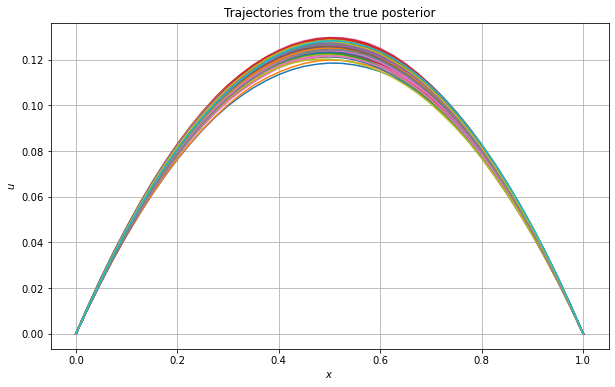

In [ ]:
#hide_input
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(grid,u_sim)
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('Trajectories from the true posterior')
plt.grid()
plt.show()

Let's now get the maximum value for each simulated curve and store this in a variable `max_true` for future use. We plot the histogram for these maximum values.

In [ ]:
max_true = u_sim.max(axis=0)

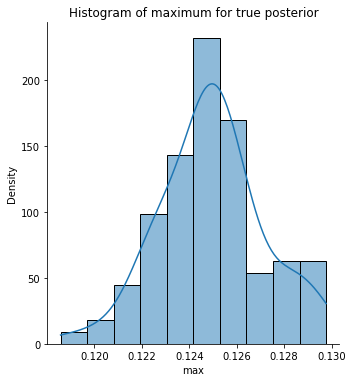

In [ ]:
#hide_input
sns.displot(max_true,kde=True,stat="density")
plt.xlabel('$\max$')
plt.title('Histogram of maximum for true posterior')
plt.show()

# Sampling from statFEM posterior maxiumum distribution in 1D

We now create a function to utilise FEniCS to draw trajectories from the statFEM posterior.

In [ ]:
def statFEM_posterior_sampler(n_sim, grid, h, f_bar, k_f, ϵ, Y, v_dat, par = False, trans = True, tol = 1e-9):
    # get length of grid
    d = len(grid)
    
    # get size of FE mesh
    J = int(np.round(1/h))
    
    # get statFEM posterior mean function
    m_post_fem = m_post_fem_assembler(J,f_bar,k_f,ϵ,Y,v_dat)
    μ_func = MyExpression()
    μ_func.f = m_post_fem
    
    # evaluate this on the grid
    μ = np.array([μ_func(x) for x in grid]).reshape(d,1)
    
    # get statFEM posterior cov mat on grid
    Σ = c_post_fem_assembler(J,k_f,grid,Y,ϵ,False,True)
    
    # construct the cholesky decomposition Σ = GG^T
    # we add a small diagonal perturbation to Σ to ensure it
    # strictly positive definite
    G = np.linalg.cholesky(Σ + tol * np.eye(d))

    # draw iid standard normal random vectors
    Z = np.random.normal(size=(d,n_sim))

    # construct samples from GP(m,k)
    Y = G@Z + np.tile(μ,n_sim)

    # return the sampled trajectories
    return Y

Let's test this function out by using it to obtain samples from the statFEM posterior for a particular value of $h$.

In [ ]:
%%time
h = 0.1
np.random.seed(3542)
u_sim_statFEM = statFEM_posterior_sampler(n_sim, grid, h, f_bar, k_f, ϵ, Y, v_dat)

CPU times: user 102 ms, sys: 4.63 ms, total: 107 ms
Wall time: 98.5 ms


Let's plot the above trajectories.

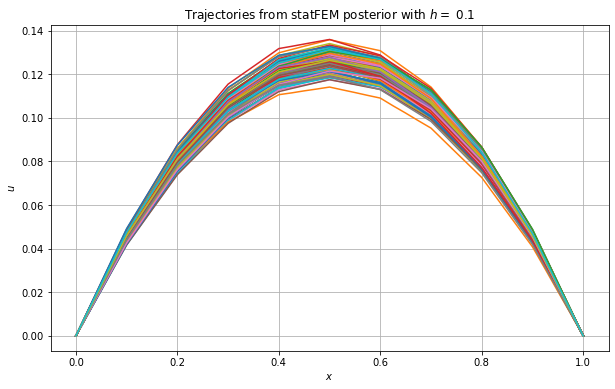

In [ ]:
#hide_input
plt.rcParams['figure.figsize'] = (10,6)
plt.plot(grid,u_sim_statFEM)
plt.grid()
plt.xlabel('$x$')
plt.ylabel('$u$')
plt.title('Trajectories from statFEM posterior with $h = $ %0.1f' % h)
plt.show()

Let's now get the maximum value for each simulated curve and store this in a variable `max_statFEM` for future use. We then plot the histograms for these maximum values together with those from the true posterior.

In [ ]:
max_statFEM = u_sim_statFEM.max(axis=0)

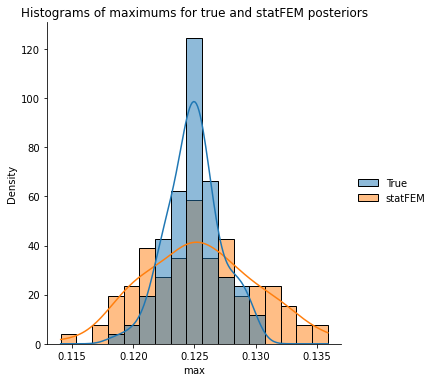

In [ ]:
#hide_input
max_data = pd.DataFrame(data={'True': max_true, 'statFEM': max_statFEM})
sns.displot(max_data,kde=True,stat="density")
plt.xlabel('$\max$')
plt.title('Histograms of maximums for true and statFEM posteriors')
plt.show()

Our `wass` function requires the number of bins to be specified. Let's investigate how varying this parameter affects the computed distance between the true maximums and our statFEM maximums.

In [ ]:
n_bins = np.arange(10,200,10)
wass_bin_dat = [wass(max_true,max_statFEM,n) for n in n_bins]

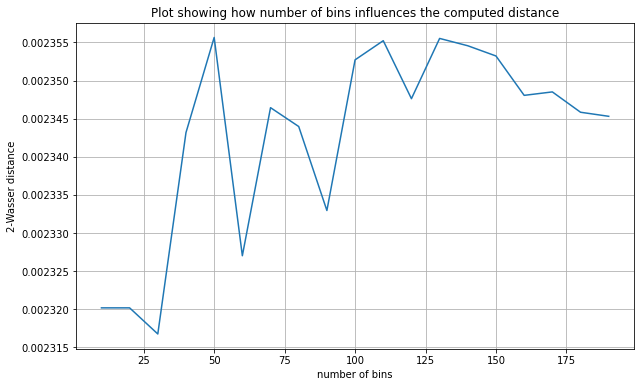

In [ ]:
#hide_input
plt.plot(n_bins,wass_bin_dat)
plt.grid()
plt.xlabel('number of bins')
plt.ylabel('2-Wasser distance')
plt.title('Plot showing how number of bins influences the computed distance')
plt.show()

From the plot above we see that the distance seems to stabilize after around $100$ bins. We choose to take `n_bins=150` for the rest of this example.

We now set up a range of $h$-values to use for the statFEM posterior.

In [ ]:
# set up range of h values to use
h_range_tmp = np.linspace(0.25,0.02,100)
h_range = 1/np.unique(np.round(1/h_range_tmp))
np.round(h_range,2)

array([0.25, 0.2 , 0.17, 0.14, 0.12, 0.11, 0.1 , 0.09, 0.08, 0.08, 0.07,
       0.07, 0.06, 0.06, 0.06, 0.05, 0.05, 0.05, 0.05, 0.04, 0.04, 0.04,
       0.04, 0.03, 0.03, 0.03, 0.03, 0.02, 0.02, 0.02])

We now loop over these $h$-values, and for each value we simulate maximums from the statFEM posterior and then compute the 2-Wasserstein distance between these maximums and those from the true posterior.

In [ ]:
%%time
errors = []
###################
n_bins = 150
##################
np.random.seed(3252)
for h in tqdm(h_range):
    # sample trajectories from statFEM prior for current h value
    sim = statFEM_posterior_sampler(n_sim, grid, h, f_bar, k_f, ϵ, Y, v_dat)
    # get max
    max_sim = sim.max(axis=0)
    # compute error
    error = wass(max_true,max_sim,n_bins)
    # append to errors
    errors.append(error)

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 7.22 s, sys: 16.5 s, total: 23.8 s
Wall time: 3.39 s


In [ ]:
#hide
errors = np.array(errors)

We see that as $h$ decreases so too does the distance/error. Let's investigate the rate by plotting this data in log-log space and then estimating the slope of the line of best fit.

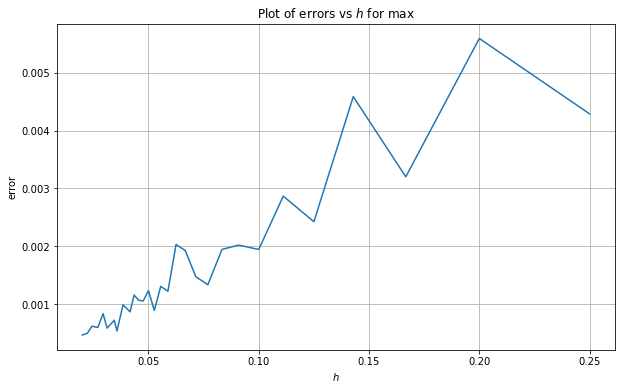

In [ ]:
#hide_input
plt.plot(h_range,errors)
plt.grid()
plt.xlabel('$h$')
plt.ylabel('error')
plt.title('Plot of errors vs $h$ for $\max$')
plt.show()

We see that as $h$ decreases so too does the distance/error. Let's investigate the rate by plotting this data in log-log space and then estimating the slope of the line of best fit.

slope: 0.994518    intercept: -3.811136    r value: 0.960895     p value: 0.000000


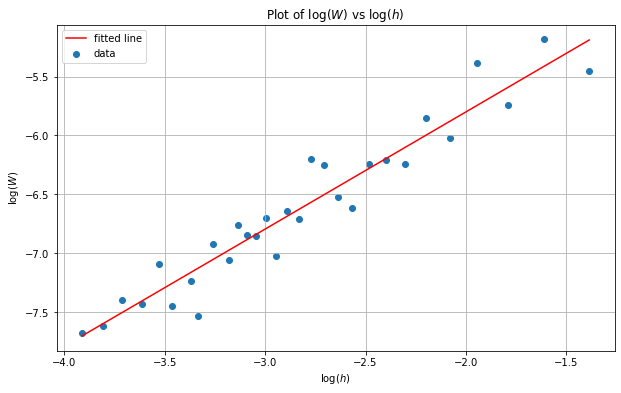

In [ ]:
#hide_input
log_h_range = np.log(h_range)
log_errors = np.log(errors)

# perform linear regression to get line of best fit for the log scales:
lm = linregress(log_h_range,log_errors)
print("slope: %f    intercept: %f    r value: %f     p value: %f" % (lm.slope, lm.intercept, lm.rvalue, lm.pvalue))

# plot line of best fit with the data:
x = np.linspace(np.min(log_h_range),np.max(log_h_range),100)
plt.scatter(log_h_range,log_errors,label='data')
plt.plot(x,lm.intercept + lm.slope * x, 'r', label='fitted line')
#plt.plot(x,-1+2*x,'--',c='black',label='reference line')
plt.grid()
plt.legend()
plt.xlabel('$\log(h)$')
plt.ylabel('$\log(W)$')
plt.title('Plot of $\log(W)$ vs $\log(h)$')
plt.savefig('1D_prior_results.png',dpi=300,bbox_inches='tight',facecolor="w")
plt.show()

We can see from the above plot that the slope is around $1$ - this differs from our theory showing the results for the $\max$ are out of the remit of our theory.

We now repeat the above for different levels of sensor noise.

In [ ]:
ϵ_list = [0.01,0.1,0.2,0.5,1.0]
results = {}

In [ ]:
%%time
np.random.seed(345346)
tol = 1e-10
n_sim = 100
for ϵ in tqdm(ϵ_list,desc='Eps loop'):
    # generate sensor data
    v_dat = gen_sensor(ϵ,m_f,k_f,Y,u_quad,grid,maxiter=400)
    # get true B mat required for posterior
    B_true = (ϵ**2)*np.eye(s) + C_true_s

    # set up true posterior mean
    def true_mean(x):
        return m_post(x,μ_true,c_u_vect,v_dat,Y,B_true)
    
    # set up true posterior covariance
    def c_post_true(x,y):
        return c_post(x,y,c_u,Y,B_true)
    
    u_sim = sample_gp(n_sim, true_mean, c_post_true, grid,True,False)
    
    max_true = u_sim.max(axis=0)
    
    errors = []
    
    for h in tqdm(h_range):
        # sample trajectories from statFEM prior for current h value
        sim = statFEM_posterior_sampler(n_sim, grid, h, f_bar, k_f, ϵ, Y, v_dat)
        # get max
        max_sim = sim.max(axis=0)
        # compute error
        error = wass(max_true,max_sim,n_bins)
        # append to errors
        errors.append(error)
        
    results[ϵ] = errors

Eps loop:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 1min 59s, sys: 1min 29s, total: 3min 28s
Wall time: 21min 22s


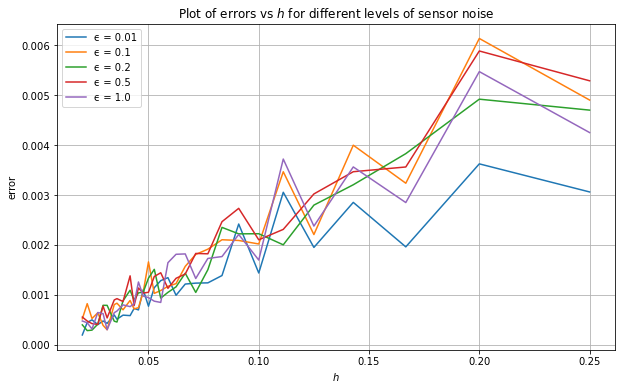

In [ ]:
#hide_input
plt.plot()
plt.grid()
plt.xlabel('$h$')
plt.ylabel('error')
plt.title('Plot of errors vs $h$ for different levels of sensor noise')
for ϵ in ϵ_list:
    errors = results[ϵ]
    plt.plot(h_range,errors, label = 'ϵ = ' + str(ϵ))
plt.legend()
plt.show()

ϵ: 0.01,    slope: 1.0304,    intercept: -3.9880
ϵ: 0.10,    slope: 1.0617,    intercept: -3.6566
ϵ: 0.20,    slope: 1.1218,    intercept: -3.5605
ϵ: 0.50,    slope: 1.0526,    intercept: -3.6205
ϵ: 1.00,    slope: 1.0895,    intercept: -3.6371


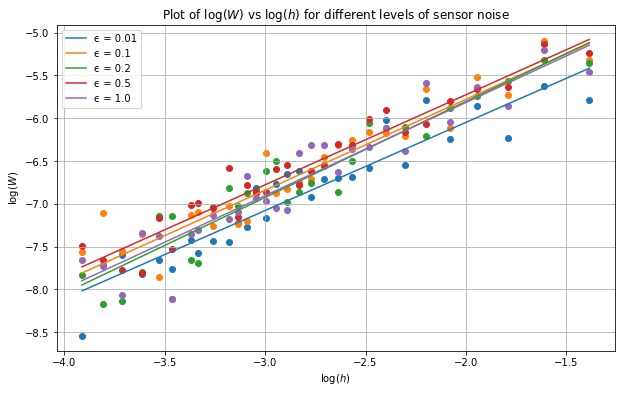

In [ ]:
#hide_input
plt.plot()
plt.grid()
plt.xlabel('$\log(h)$')
plt.ylabel('$\log(W)$')
plt.title('Plot of $\log(W)$ vs $\log(h)$ for different levels of sensor noise')
log_h_range = np.log(h_range)
for ϵ in ϵ_list:
    errors = results[ϵ]
    log_errors = np.log(errors)
    lm = linregress(log_h_range,log_errors)
    print('ϵ: %.2f,    slope: %.4f,    intercept: %.4f' % (ϵ, lm.slope,lm.intercept))
    plt.scatter(log_h_range,log_errors)
    plt.plot(x,lm.intercept + lm.slope * x, label='ϵ = ' +str(ϵ))
plt.legend()
plt.show()

We can see that in all cases the rate is around 1.